# TEA-DT Community Pulse Check
## Insight into user readiness for TEA
RQ3: How satisfied are practitioners with their current assurance practices?

RQ5: Which sectors & stakeholders have high potential for adopting the TEA-DT tool, i.e have a need for it, see its value and have the conditions to adopt it. And what support is needed to drive adoption?

## Table of Contents
1. [Data Preprocesssing](#load_and_preprocess)
2. [Quick Summary](#quick-summary)
3. [Custom Grouping](#grouping)
4. [Results](#results)
    - 4.1. [Satisfaction](#satisfaction)
    - 4.2. [Readiness](#aba-readiness--needs)

In [41]:
# %% 
# Imports
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from collections import Counter
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


In [42]:
# Define Plotting functions   

def plot_pie_chart(df, category_col, title="Pie Chart", highlight=None, dpull=0, label_length=100, palette=None, outfile=None):
    df[category_col] = df[category_col].astype(str).str[:label_length]
    # Count the occurrences for each category
    counts = df[category_col].value_counts().reset_index()
    counts.columns = [category_col, 'count']
    
    # Determine which sections to highlight
    if highlight is None:
        pull = [dpull] * len(counts)
    else:
        if isinstance(highlight, str):
            highlight = [highlight]
        pull = [dpull if counts[category_col][i] in highlight else 0 for i in range(len(counts))]

    # Plot the pie chart
    fig = px.pie(counts, values='count', names=category_col, title=title,
                 color_discrete_sequence=palette)
    
    # Update layout to show labels outside the pie chart with leader lines
    fig.update_traces(textinfo='label', textposition='outside', showlegend=False,
                      marker=dict(line=dict(color='#000000', width=2)), pull=pull,
                      hole=0.3, textfont_size=16)

    # Add title and adjust margins
    fig.update_layout(title_text=title, title_x=0.5, margin=dict(t=50, b=0, l=0, r=0))
    
    if outfile:
        fig.write_image(f"{outfile}.svg")

    return fig

def barplot_grouped(df, plot_val, group_by, group1, group2, category_order=None):
    # Filter the DataFrame for the specified roles
    filtered_df = df[df[group_by].isin([group1, group2])]

    # Calculate the frequency counts
    freq_counts = filtered_df.groupby([plot_val, group_by]).size().unstack(fill_value=0).reset_index()

    # Calculate the total count of unique respondents for each group
    total_counts = df.groupby(group_by)['_id'].nunique()

    # Convert frequencies to percentages
    freq_counts[f'{group1}_percent'] = (freq_counts[group1] / total_counts[group1]) * 100
    freq_counts[f'{group2}_percent'] = (freq_counts[group2] / total_counts[group2]) * 100

    # Sort by difference in percentages
    freq_counts['diff'] = abs(freq_counts[f'{group1}_percent'] - freq_counts[f'{group2}_percent'])
    freq_counts = freq_counts.sort_values(by='diff', ascending=False)

    # Create a new DataFrame for plotting
    plot_df = pd.DataFrame({
        plot_val: pd.concat([freq_counts[plot_val], freq_counts[plot_val]]),
        group_by: [group1] * len(freq_counts) + [group2] * len(freq_counts),
        'Frequency': pd.concat([freq_counts[group1], freq_counts[group2]]),
        'Percentage': pd.concat([freq_counts[f'{group1}_percent'], freq_counts[f'{group2}_percent']])
    })

    # Create the bar plot
    fig = px.bar(plot_df, x=plot_val, y='Percentage', color=group_by, barmode='group',
                 title=f'Percentage Frequency of {plot_val} for {group_by} "{group1}" and "{group2}"',
                 hover_data={'Frequency': True},
                category_orders={plot_val: category_order})

    # Update layout
    fig.update_layout(xaxis_title=plot_val, yaxis_title='Percentage')

    # Show the plot
    fig.show()

def plot_sankey(df, source_column, target_column):

    # Group by source and target to get the count (value) of each unique pair
    df_grouped = df.groupby([source_column, target_column]).size().reset_index(name='value')

    # Create a list of unique labels (nodes) from both columns
    all_labels = pd.concat([df_grouped[source_column], df_grouped[target_column]]).unique()

    # Create a dictionary to map labels to indices
    label_to_index = {label: i for i, label in enumerate(all_labels)}

    # Map the source and target columns to their corresponding indices
    df_grouped['source_index'] = df_grouped[source_column].map(label_to_index)
    df_grouped['target_index'] = df_grouped[target_column].map(label_to_index)

    # Create the Sankey diagram
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_labels
        ),
        link=dict(
            source=df_grouped['source_index'],
            target=df_grouped['target_index'],
            value=df_grouped['value']  # Use the count of rows as values
        )
    ))

    # Set the title and display the Sankey diagram
    fig.update_layout(title_text="Sankey Diagram", font_size=10)
    fig.show()

def barplot(df, plot_val, category_order=None, palette=None, outfile=None):
    # Calculate the total count of unique respondents (using _id)
    total_count = df['_id'].nunique()

    # Calculate the frequency counts
    freq_counts = df.groupby(plot_val)['_id'].nunique().reset_index()
    freq_counts.columns = [plot_val, 'Frequency']

    # Convert frequencies to percentages based on the total unique _id count
    freq_counts['Percentage'] = (freq_counts['Frequency'] / total_count) * 100
    # Sort by percentage
    freq_counts = freq_counts.sort_values(by='Percentage', ascending=True)

    # Create the bar plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=freq_counts, y=plot_val, x='Percentage', palette=palette, order=category_order)

    # Customize the grid and background
    ax = plt.gca()  # Get current axes
    ax.set_facecolor('#E8E8E8')  # Set grey background
    ax.grid(axis='x', color='white', linestyle='-', linewidth=1)  # White vertical lines
    ax.grid(axis='y', linestyle='')  # Remove horizontal lines
    ax.tick_params(length=0)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))  # Control number of ticks on the x-axis

    # Customize the grid: remove horizontal lines but keep vertical ones
    plt.grid(axis='y', linestyle='')  # Remove horizontal lines
    plt.grid(axis='x', linestyle='-')  # Keep vertical lines
    # Ensure the bars are in front of the grid lines
    for bar in ax.patches:
        bar.set_zorder(3)

    # Remove the black frame (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Update the layout
    plt.title(f'Percentage of {plot_val} based on Unique Respondents')
    plt.xlabel('Percentage')
    plt.ylabel(plot_val)

    plt.tight_layout()

    if outfile:
        plt.savefig(outfile, format='svg')
    plt.show()


# Define other helper functions
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [43]:
color_hex_codes = {
    # Blues
    "Cyan": "#00B4DF",        # 100% color
    "Cyan_25": "#40C7E7",     # 75% color, 25% white
    "Cyan_50": "#80D9EF",     # 50% color, 50% white
    "Cyan_75": "#BFECF7",      # 25% color, 75% white
    
    "Blue": "#0073B4",        # 100% color
    "Blue_25": "#4096C7",     # 75% color, 25% white
    "Blue_50": "#80B9DA",     # 50% color, 50% white
    "Blue_75": "#BFDCEC",     # 25% color, 75% white
    
    # Greens
    "Green": "#337538",       # 100% color
    "Green_25": "#66976A",    # 75% color, 25% white
    "Green_50": "#99BA9B",    # 50% color, 50% white
    "Green_75": "#CCDCCD",    # 25% color, 75% white
    
    "BlueGreen": "#009D72",        # 100% color
    "BlueGreen_25": "#40B595",     # 75% color, 25% white
    "BlueGreen_50": "#80CEB8",     # 50% color, 50% white
    "BlueGreen_75": "#BFE6DC",     # 25% color, 75% white

    "Teal": "#5DA899",        # 100% color
    "Teal_25": "#85BEB2",     # 75% color, 25% white
    "Teal_50": "#AED3CC",     # 50% color, 50% white
    "Teal_75": "#D6E9E5",     # 25% color, 75% white
    
    # Yellows
    "Yellow": "#CCBB40",      # 100% color
    "Yellow_25": "#D9CC70",   # 75% color, 25% white
    "Yellow_50": "#E5DD9F",   # 50% color, 50% white
    "Yellow_75": "#F2EECF",   # 25% color, 75% white
    
    "Lemon": "#F0E442",       # 100% color
    "Lemon_25": "#F4EB71",    # 75% color, 25% white
    "Lemon_50": "#F7F1A0",    # 50% color, 50% white
    "Lemon_75": "#FBF8D0",    # 25% color, 75% white
    
    # Oranges
    "Orange": "#E69F03",      # 100% color
    "Orange_25": "#ECB742",   # 75% color, 25% white
    "Orange_50": "#F2CF81",   # 50% color, 50% white
    "Orange_75": "#F9E7C0",   # 25% color, 75% white
    
    # Reds
    "Red": "#D45F14",         # 100% color
    "Red_25": "#DF874F",      # 75% color, 25% white
    "Red_50": "#E9AF89",      # 50% color, 50% white
    "Red_75": "#F4D7C4",      # 25% color, 75% white
    
    # Pinks
    "Pink": "#CC78A7",        # 100% color
    "Pink_25": "#D99ABD",     # 75% color, 25% white
    "Pink_50": "#E5BBD3",     # 50% color, 50% white
    "Pink_75": "#F2DDE9",     # 25% color, 75% white
    
    "Magenta": "#9F4A96",     # 100% color
    "Magenta_25": "#B777B0",  # 75% color, 25% white
    "Magenta_50": "#CFA4CA",  # 50% color, 50% white
    "Magenta_75": "#E7D2E5",  # 25% color, 75% white
    
    # Purples
    "Purple": "#812C55",      # 100% color
    "Purple_25": "#A06180",   # 75% color, 25% white
    "Purple_50": "#C095AA",   # 50% color, 50% white
    "Purple_75": "#DFC4D4",   # 25% color, 75% white
    
    # Grays
    "Gray": "#BBBBBB",        # 100% color
    "Gray_25": "#E8E8E8",     # 75% color, 25% white
}

def select_colors(total_items, primary_colors):

    # Calculate how many mixed colors are needed per primary color
    num_primary = len(primary_colors)
    num_mixed_per_primary = (total_items - num_primary) // num_primary
    
    if (total_items - num_primary) % num_primary != 0:
        num_mixed_per_primary += 1

    selected_colors = []
    
    # Iterate over each primary color in the specified list
    for color in primary_colors:
        selected_colors.append(color_hex_codes[color])
        if len(selected_colors) < total_items:
            if num_mixed_per_primary >= 1:
                selected_colors.append(color_hex_codes.get(f"{color}_25"))
            if num_mixed_per_primary >= 2 and len(selected_colors) < total_items:
                selected_colors.append(color_hex_codes.get(f"{color}_50"))
            if num_mixed_per_primary >= 3 and len(selected_colors) < total_items:
                selected_colors.append(color_hex_codes.get(f"{color}_75"))

    return selected_colors[:total_items]

# Example usage
#colors_for_6_items = select_colors(6, ['Cyan', 'Green', 'Yellow'])  # Select 3 primary colors and 1 mixed version for each


## Load & Preprocess
<a id="load_and_preprocess"></a>

In [44]:
# Load Data
csv_file_path = 'tea_dt_data_full.csv'
df = pd.read_csv(csv_file_path)

In [45]:
# Clean cells
def split_at_parentheses(text):
    if isinstance(text, str):
        return text.split('(')[0].strip()
    return text

def melt_multiple_select(df, columns, new_col_name):
    melted_df = df.melt(id_vars=['_id'], value_vars=columns, var_name='variable', value_name=new_col_name).dropna(subset=[new_col_name])
    return melted_df

def merge_columns(df, columns):
    """
    Merges multiple columns into a single list column, 
    excluding 'Other' across all columns if any column contains 'other' in its name.
    
    Parameters:
    df (DataFrame): The DataFrame containing the columns to merge.
    columns (list): List of columns to merge.
    
    Returns:
    Series: A pandas Series containing the merged lists.
    """
    # Check if any column name contains 'other'
    contains_other = any('other' in col.lower() for col in columns)
    
    return df[columns].apply(
        lambda row: [
            item for item in row 
            if pd.notna(item) and not (contains_other and item == "Other")
        ],
        axis=1
    )

df = df.map(split_at_parentheses)

In [46]:
# Re-code "Other" entries

# Step 1: Merge all columns that are 'select_all' and had "specify other" option
select_all_cols = ['type_dt','purpose_dt','assurance_mechanism','assured_properties','support_for_assurance']

for col_name in select_all_cols:
    df[f'{col_name}_combined'] =  merge_columns(df, [col for col in df.columns if col.startswith(col_name)])

# Step2 2: manually re-code "other" entries
# dict = {'response given': 'mapped onto'}
replace_type_dict={
    'Patient DT': "Patient",
    'Digital twins of patient organs/systems': "Patient",
    'Interconnections between 3rd party digital twins': "Connectivity",
    'We have developed Digital Twin system for Offshore Energy Floating Offshore Wind, Wave Energy and Oil &Gas': np.nan,
    'Maritime': np.nan,
    'We are building a universal connected and semantic digital twin called The World Avatar':["Semantic", "Connectivity"],
    'Product Digital Twin for an Extra Large Autonomous Underwater Vehicle': "Physical asset",
    'Emissions, predictive health monitoring, LCA, logistics': np.nan, #respondent selected categories AND filled in "Other" ,
 }
df['type_dt_combined'] = df['type_dt_combined'].apply(lambda x: [replace_type_dict.get(item, item) for item in x] )


replace_purpose_dict={
    'any purpose from atomic to planetary the digital twin is not related to a specific application but aims to represent any application.':
        ["Internal Operations","External Collaboration","Public Impact", "Market / Customer Engagement", "Research and Development"],    
}
df['purpose_dt_combined'] = df['purpose_dt_combined'].apply(lambda x: [replace_purpose_dict.get(item, item) for item in x] )


replace_mechanisms_dict={
    'all of the aspects metioned': ["Bias Reviews", "Compliance Audits", "Conformity Assessments", "Stakeholder Feedback Systems","Risk Assessment", "Impact Assessment", "Information Security Reviews",
                                    "Data Quality Checks", "Formal Verification", "Post-Implementation Evaluation", "Service Continuity Management", "Performance Monitoring", "Operational Audits", "Service Quality Reviews"],
    'Extensive governance and oversight throughout the lifecycle of a project.': ["Governance", "Oversight"],
    'What’s appropriate to the purpose intended': np.nan,
    'Claims based assurance - reviewing evidence to validate specific claims about the performance and operations of a Digital Twin.\\nMaturity Assessment - assessing the maturity of the organisation and their ability to manage and maintain DTs.': ['Claims-based assurance', 'Maturity assessment'],
}
df['assurance_mechanism_combined'] = df['assurance_mechanism_combined'].apply(lambda x: [replace_mechanisms_dict.get(item, item) for item in x] )


replace_properties_dict={
    'Digital twinning technology is different from digital twin, like a bucket is different from the water it contains. When selecting or assuring the technology I would assure myself that the requirements are clear, understood and that the technology provided meets those requirements.': ["Fit-for-purpose", "Transparency"],
    'all of the aspects mentioned': ["Accountability", "Contestability","Data Quality","Data Stewardship","Ethical Integrity","Evolution","Explainability","Fairness","Federation","Financial Performance","Fit-for-purpose",
            "Governance","Interoperability","Openness","Public Good","Reliability/Robustness","Resilience / Fault-tolerance","Safety","Security","Sustainability","Transparency","Trustworthiness","Value Creation",]
}
df['assured_properties_combined'] = df['assured_properties_combined'].apply(lambda x: [replace_properties_dict.get(item, item) for item in x] )


replace_support_dict={
    'We are a micro enterprise': np.nan,
    'I work on structured arguments': np.nan
}
df['support_for_assurance_combined'] = df['support_for_assurance_combined'].apply(lambda x: [replace_support_dict.get(item, item) for item in x] )

for column_name in select_all_cols:
    df[f'{column_name}_combined'] = df[f'{column_name}_combined'].apply(
    lambda x: np.nan if not any(x) else [item for sublist in x for item in (sublist if isinstance(sublist, list) else [sublist])]
)

## Quick Summary
<a id="quick_summary"></a>

### Survey stats

In [47]:
print("Total number of responses:",df.shape[0])

# Ensure the timestamps are in datetime format and compute the time spent in minutes
df['start_timestamp'] = pd.to_datetime(df['start_timestamp'])
df['modification_date'] = pd.to_datetime(df['modification_date'])
df['time_spent_minutes'] = (df['modification_date'] - df['start_timestamp']).dt.total_seconds() / 60.0

# Check for responses that span multiple days
if (df['modification_date'].dt.date != df['start_timestamp'].dt.date).any():
    print("Warning: some responses span multiple days")

# Remove the 5% most extreme times and compute the mean time spent
mean_time_spent = df['time_spent_minutes'].mean()

# Print the mean duration spent on the survey
print("Mean duration spent on survey:", mean_time_spent)

Total number of responses: 50
Mean duration spent on survey: 18.1


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27905/1740247436.py:4: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27905/1740247436.py:5: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



### Community Composition

In [48]:
# Generate the individual figures
pie_location = plot_pie_chart(df, 'location')
pie_role = plot_pie_chart(df, 'role')
pie_sector = plot_pie_chart(df, 'sector')
responsibility_columns = [col for col in df.columns if col.startswith('primary_responsibilities')]
responsibility_melted = melt_multiple_select(df, responsibility_columns, 'primary_responsibilities',)
pie_responsibility = plot_pie_chart(responsibility_melted, 'primary_responsibilities')
pie_established = plot_pie_chart(df, 'established_dt')

select_all_cols = ['type_dt','purpose_dt','assurance_mechanism','assured_properties','support_for_assurance_other']


established_reason_columns = [col for col in df.columns if col.startswith('no_dt_reason')]
established_reason_melted = melt_multiple_select(df, established_reason_columns, 'no_dt_reason',)
pie_established_reason= plot_pie_chart(established_reason_melted, 'no_dt_reason')

type_exploded = df.explode('type_dt_combined').reset_index(drop=True)
pie_type = plot_pie_chart(type_exploded, 'type_dt_combined')

purpose_exploded = df.explode('purpose_dt_combined').reset_index(drop=True)
pie_purpose = plot_pie_chart(purpose_exploded, 'purpose_dt_combined')



# Create a subplot figure with 1 row and 2 columns
# Create a grid of 4 rows and 2 columns for the plots with domain type subplots for pie charts
fig = make_subplots(rows=4, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}],
                                           [{'type': 'domain'},{'type': 'domain'}],
                                           [{'type': 'domain'},{'type': 'domain'}],
                                           [{'type': 'domain'},{'type': 'domain'}]],
                   subplot_titles=("Location", "Role", "Primary Responsibility", "", "Has established a digital twin", 
                                   "Reasons for not yet established a DT", "Types of digital twins established", 
                                   "Purpose of digital twins established"))

# Add traces from the individual figures to the subplot
fig.add_trace(pie_location['data'][0], row=1, col=1)
fig.add_trace(pie_role['data'][0], row=1, col=2)
fig.add_trace(pie_responsibility['data'][0], row=2, col=1)
fig.add_trace(pie_sector['data'][0], row=2, col=2)
fig.add_trace(pie_established['data'][0], row=3, col=1)
fig.add_trace(pie_established_reason['data'][0], row=3, col=2)
fig.add_trace(pie_type['data'][0], row=4, col=1)
fig.add_trace(pie_purpose['data'][0], row=4, col=2)

# Update layout
fig.update_layout(title_text="Location and Role Pie Charts", height=1200, width=1000, margin=dict(t=50, l=200, r=200, b=50))
# Show the combined figure
fig.show()


## Custom Grouping
<a id="grouping"></a>

Across all responses we recorded 6 of the 7 role options given. Group sizes across roles are not of equal size. In addition, the set of primary responsibilities selected for each role were very heterogeneous. The distribution suggests a sector in the process of maturing with both highly specialized roles but also roles with a wide scope of responsibilities (often associated with small teams).

To allow grouping of later results we apply a data-driven clustering approach to find equally sized groups based on the selection of responsibilities.

In [49]:
# Step 1: Compute similarity between sets of responsibilities

# Identify all relevant olumns
responsibility_columns = [col for col in df.columns if col.startswith('primary_responsibilities[')]
responsibility_sets = df[responsibility_columns].apply(lambda row: set(row.dropna()), axis=1)

# Compute Jaccard similarity matrix
n = len(responsibility_sets)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        similarity = jaccard_similarity(responsibility_sets[i], responsibility_sets[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity  # Symmetric matrix

In [50]:
# Step 2: Perform hierarchical clustering
thresh =5
linked = linkage(similarity_matrix, method='ward')
df['cluster_id'] = fcluster(linked, t=thresh, criterion='maxclust')

In [51]:
# Loop through each unique cluster_id
df['responsibilities'] = responsibility_sets

for cluster_id, group in df.groupby('cluster_id'):
    responsibilities_sets = group['responsibilities']
    
    # Count the number of responses in this cluster
    row_count = len(group)
    
    # Initialize a Counter for the responsibilities
    combined_counter = Counter()
    
    # Update the counter with all sets in the current cluster_id
    for responsibilities_set in group['responsibilities']:
        combined_counter.update(responsibilities_set)
    
    # Print the results for the current cluster_id
    print(f"Cluster {cluster_id}: {row_count} responses")
    print(combined_counter)
    print() 

Cluster 1: 14 responses
Counter({'Research and Innovation': 14, 'Project Leadership': 3, 'Other': 2, 'Governance Influence': 1, 'Ensuring Compliance': 1})

Cluster 2: 12 responses
Counter({'Research and Innovation': 12, 'Technical Decision-Making': 11, 'Strategic Direction': 9, 'Project Leadership': 6, 'Governance Influence': 1})

Cluster 3: 7 responses
Counter({'Strategic Direction': 7, 'Operational Management': 1, 'Ensuring Compliance': 1, 'Governance Influence': 1})

Cluster 4: 5 responses
Counter({'Project Leadership': 5, 'Operational Management': 1})

Cluster 5: 12 responses
Counter({'Technical Decision-Making': 11, 'Project Leadership': 6, 'Strategic Direction': 5, 'Operational Management': 4, 'Ensuring Compliance': 3, 'Research and Innovation': 3, 'Governance Influence': 3, 'Other': 2, 'Budget Management': 2})



### Add Grouping Based on Community Composition
Implement grouping based on responses for
- location (uk/nonuk)
- set of responsibilities
- internal vs external purpose

In [52]:
# Code groupings
# create new column with binary grouping based on location
df['uk/nonuk'] = df['location'].apply(lambda x: 'uk' if x in ["United Kingdom"] else 'non-uk')

# create new column with cluster-based grouping of role focus based on response to 'primary_responsibilities'
df.rename(columns={'cluster_id': 'role_focus'}, inplace=True)
group_labels = {
    1: "Research-Focused",
    2: "Research and Technical",
    3: "Technical and Strategic",
    4: "Leadership and Strategic",  # Combine Cluster 4 & 5
    5: "Leadership and Strategic"   # Combine Cluster 4 & 5
}
df['role_focus'] = df['role_focus'].map(group_labels)

# create new column grouping purpose into external vs internal
df['purpose_focus'] = df['purpose_dt_combined'].apply(
    lambda row: 'external' 
    if isinstance(row, list) and any(val in ["Public Impact", "External Collaboration", "Market / Customer Engagement"] for val in row) 
        else ('internal' if isinstance(row, list) 
          else np.nan)
)

In [53]:
# Generate the individual figures
pie_location = plot_pie_chart(df, 'uk/nonuk')
pie_role = plot_pie_chart(df, 'role_focus')
pie_focus = plot_pie_chart(df, 'purpose_focus')

# Create a subplot figure with 1 row and 2 columns
# Create a grid of 4 rows and 2 columns for the plots with domain type subplots for pie charts
fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
                   subplot_titles=("Location", "Role", "Purpose"))

# Add traces from the individual figures to the subplot
fig.add_trace(pie_location['data'][0], row=1, col=1)
fig.add_trace(pie_role['data'][0], row=1, col=2)
fig.add_trace(pie_focus['data'][0], row=1, col=3)

# Update layout
fig.update_layout(title_text="New Groupings", height=1200, width=1000, margin=dict(t=100, l=50, r=50, b=100))
# Show the combined figure
fig.show()


In [54]:
# Chi-square test for independence to check if one grouping may be confounding another
from scipy.stats import chi2_contingency

# List of the three categorical columns
categories = ['uk/nonuk', 'role_focus', 'purpose_focus','Assurance_experience']

# Initialize an empty list to store results
results = []

# Pairwise Chi-Square Test for each pair of columns
for i in range(len(categories)):
    for j in range(i + 1, len(categories)):
        # Create a contingency table for the two categories
        contingency_table = pd.crosstab(df[categories[i]], df[categories[j]])

        # Perform the Chi-Square Test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Append results to the list
        results.append((categories[i], categories[j], chi2, p))

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['Category 1', 'Category 2', 'Chi2', 'p-value'])

# Display the results
print(results_df)

# Interpretation: If p-value < 0.05, it suggests the pair is likely confounded


      Category 1            Category 2      Chi2   p-value
0       uk/nonuk            role_focus  9.496722  0.023366
1       uk/nonuk         purpose_focus  2.921516  0.232060
2       uk/nonuk  Assurance_experience  3.251558  0.354442
3     role_focus         purpose_focus  9.791296  0.133721
4     role_focus  Assurance_experience  9.401203  0.401093
5  purpose_focus  Assurance_experience  6.445893  0.375135


## Results
<a id="results"></a>

### Satisfaction
<a id="satisfaction"></a>



- Overall Satisfaction is high

Q: 3 Qs on process of assurance (integration into operation, communication & linking) 
- **Most often** respondents **agree** that:
    - their assurance activities extend beyond checklists and are integrated into operational practices
    - the way they communicate assurance contributes to building and maintaining trust
    - they can link assurance activities to higher-level principles guiding trustwowrthiness and ethical standards
- Respondents were **most positive** about **communication** of assurance
    - among those 13 that reported dissatisfaction on some level, the most frequent response to the question around effectiveness of communication was still "agree"

Q: How satisfied are you with how your team identifies and documents requirements, actions, and decisions in your assurance process?
- Overall, the most frequent response to **how satisfied** teams are with their assurance process was **Somewhat satisfied**
    - Among respondents with **publicly impactful DTs**, there were **fewer reports of high satisfaction**, and the most frequent response was **somewhat unsatisfied**

In [55]:
response_options = [
            "Strongly disagree",
            "Disagree",
            "Neutral",
            "Agree",
            "Strongly agree",
        ]
sel_df = df[['integrate_assurance','communication_impact','link_assurance_activities']]
# Calculate frequencies for each column
frequencies = {col: sel_df[col].value_counts().reindex(response_options, fill_value=0) for col in sel_df.columns}

# Convert the frequencies to a DataFrame
freq_df = pd.DataFrame(frequencies)

# Set positions for the bars
bar_width = 0.25
positions = [np.arange(len(response_options)) + i * bar_width for i in range(len(sel_df.columns))]

# Create the traces
traces = [
    go.Bar(
        x=[pos for pos in pos_list],
        y=freq_df[col],
        name=col,
        width=bar_width
    ) for col, pos_list in zip(sel_df.columns, positions)
]

# Create the layout
layout = go.Layout(
    barmode='group',
    xaxis=dict(title='Response Category', tickvals=positions[0], ticktext=response_options),
    yaxis=dict(title='Frequency'),
    title='Frequency of Responses for Three Different Columns'
)

# Create and show the figure
fig = go.Figure(data=traces, layout=layout)
fig.show()


In [56]:
select_from = 'purpose_focus'

category_order = ['Very unsatisfied', 'Somewhat unsatisfied', 'Neutral','Somewhat satisfied', 'Very satisfied']
sel1 = 'external'
sel2 = 'internal'
plot_val = 'satisfaction_justification'

barplot_grouped(df, plot_val, select_from, sel1, sel2, category_order=category_order)

In [57]:
response_options = [
            "Very unsatisfied",
            "Somewhat unsatisfied",
            "Neutral",
            "Somewhat satisfied",
            "Very satisfied",
        ]
sel_df = df[['satisfaction_justification']]
# Calculate frequencies for each column
frequencies = {col: sel_df[col].value_counts().reindex(response_options, fill_value=0) for col in sel_df.columns}

# Convert the frequencies to a DataFrame
freq_df = pd.DataFrame(frequencies)

# Set positions for the bars
bar_width = 0.25
positions = [np.arange(len(response_options)) + i * bar_width for i in range(len(sel_df.columns))]

# Create the traces
traces = [
    go.Bar(
        x=[pos for pos in pos_list],
        y=freq_df[col],
        name=col,
        width=bar_width
    ) for col, pos_list in zip(sel_df.columns, positions)
]

# Create the layout
layout = go.Layout(
    barmode='group',
    xaxis=dict(title='Response Category', tickvals=positions[0], ticktext=response_options),
    yaxis=dict(title='Frequency'),
    title = 'How satisfied are you with how your team identifies and documents requirements, actions, and decisions in your assurance process?'
)

# Create and show the figure
fig = go.Figure(data=traces, layout=layout)
fig.show()

### ABA Readiness & Needs
<a id="readiness_needs"></a>

In [58]:
response_options = [
            "Not prepared at all",
            "Somewhat unprepared",
            "Neutral",
            "Somewhat prepared",
            "Very prepared"]

# Specify the two roles
select_from = 'role_focus'
sel1 = 'Research-Focused'
sel2 = 'Leadership and Strategic'
plot_val = 'preparedness_for_argument'

barplot_grouped(df, plot_val, select_from, sel1, sel2,category_order=response_options)

In [59]:
source_column = 'Assurance_experience'
target_column = 'need_for_visual_tool'

plot_sankey(df, source_column, target_column)


In [60]:
source_column = 'role_focus'
target_column = 'need_for_visual_tool'

plot_sankey(df, source_column, target_column)

Users most likely to be interested in the tool are non-specialized teams providing assurance for their own projects or orgs that rely on external third parties for assurance. Those most interested are often in Research-Focused roles.

In [61]:
# Generate the individual figures
plot_pie_chart(df, 'need_for_visual_tool',label_length=10)
#pie_ethics = plot_pie_chart(df, 'ethical_framework_existence')
plot_pie_chart(df, 'ethical_framework_existence',palette=['#40B595','#00B4DF','#80D9EF','#CC78A7','#E5BBD3','#E8E8E8','#F2DDE9'],dpull=0.05,outfile='report_plots/ethics_framework.svg')



/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27905/513983763.py:121: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




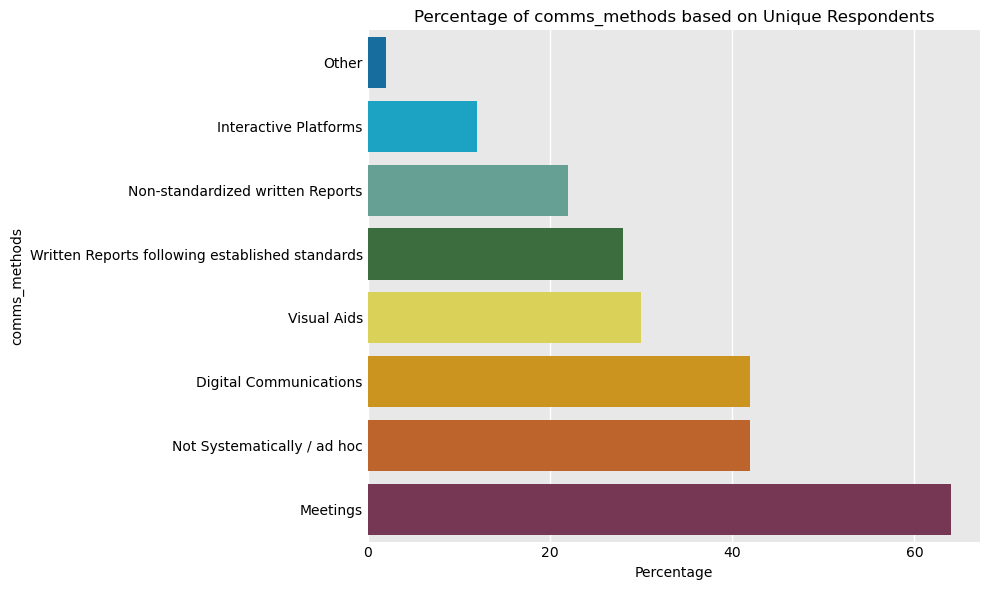

In [62]:
x_columns = [col for col in df.columns if col.startswith('communication_methods')]
x_new = melt_multiple_select(df, x_columns, 'comms_methods')

mycolor = select_colors(8, ["Blue","Cyan", "Teal","Green","Lemon", "Orange","Red", "Purple"])
barplot(x_new, 'comms_methods',palette=mycolor,outfile='report_plots/comms.svg')


In [63]:
challenges_columns = [col for col in df.columns if col.startswith('challenges_adoption')]
challenges_melted = melt_multiple_select(df, challenges_columns, 'challenges_adoption',)
pie_challenges = plot_pie_chart(challenges_melted, 'challenges_adoption')

support_exploded = df.explode('support_for_assurance_combined').reset_index(drop=True)
pie_support= plot_pie_chart(support_exploded, 'support_for_assurance_combined')

# Create a subplot figure with 1 row and 2 columns
# Create a grid of 4 rows and 2 columns for the plots with domain type subplots for pie charts
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                   subplot_titles=("What prevents you from adopting ABA?",
                                   "What support would help with ABA for ethical principles?"))

# Add traces from the individual figures to the subplot
fig.add_trace(pie_challenges['data'][0], row=1, col=1)
fig.add_trace(pie_support['data'][0], row=1, col=2)

# Update layout
fig.update_layout(title_text="Pie Charts", height=500, width=1400)
# Show the combined figure
fig.show()

In [64]:
plot_pie_chart(challenges_melted, 'challenges_adoption')

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27905/513983763.py:121: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




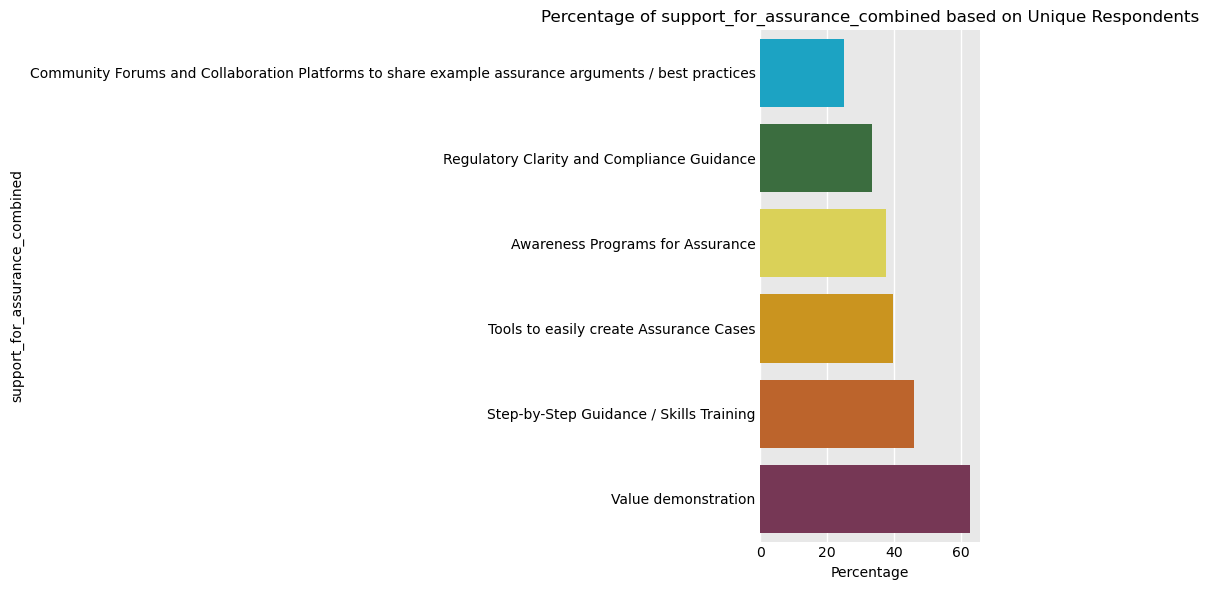

In [65]:
mycolor = select_colors(6, ["Cyan", "Green", "Lemon", "Orange","Red", "Purple"])
support_exploded = support_exploded[support_exploded['support_for_assurance_combined']!='nan']

barplot(support_exploded, 'support_for_assurance_combined',palette=mycolor,outfile='report_plots/support_tool.svg')


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27905/513983763.py:121: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_27905/513983763.py:121: UserWarning:


The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.



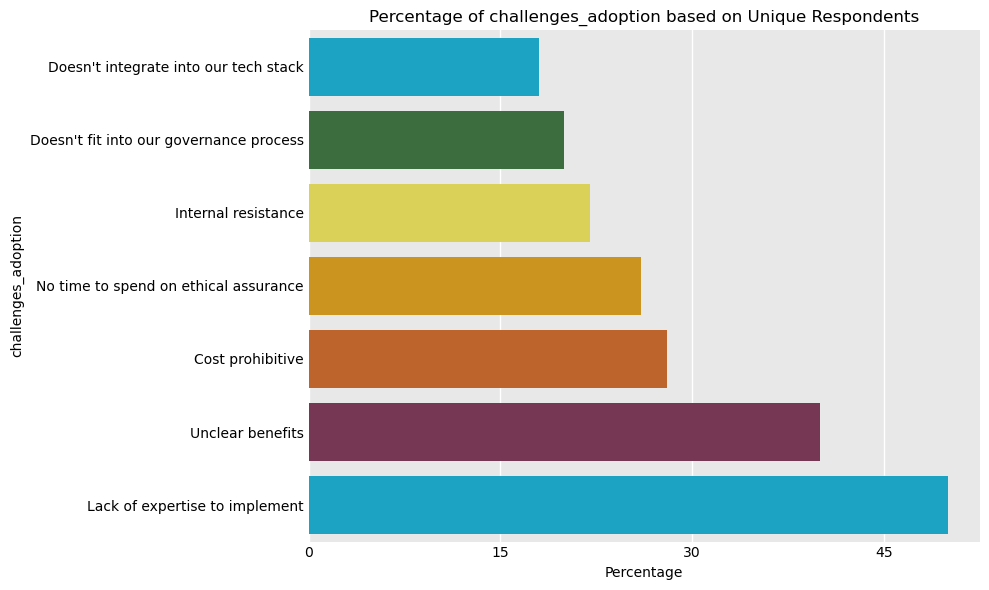

In [66]:

barplot(challenges_melted, 'challenges_adoption',palette=mycolor,outfile='report_plots/challenges_tool.svg')


### Question: What type of support might help you in creating sound assurance arguments around ethical principles for your digital tiwn project?

The majority of responses selected **value demonstration** as needed in order to adopt ABA, with a distinct group (n=7) selecting this as the ONLY type of support required.

The next most frequent responses was **skill training** but respondents usually chose this option in combination with additional support mechanisms.

**Community forums and collaboration platforms** were the least often selected option, with about 1/4th of respondents selecting this as a type of needed support.

<Axes: ylabel='Frequency'>

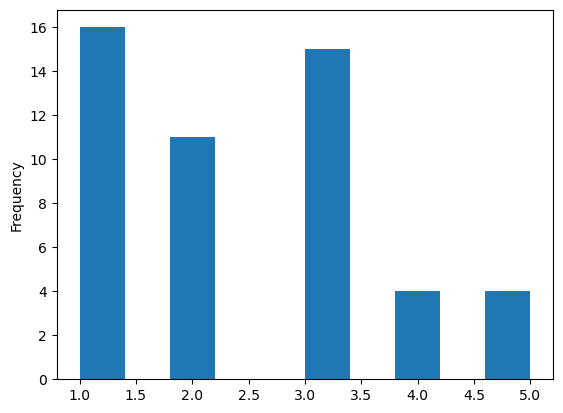

In [67]:
df['support_for_assurance_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0).plot(kind='hist')

In [68]:
tuples_series = df['support_for_assurance_combined'].apply(lambda x: tuple(sorted(x)) if isinstance(x, list) else ())

# Step 2: Count the occurrences of each unique tuple
unique_lists_counts = tuples_series.value_counts()

# Step 3: Optionally convert the tuples back to lists for display
unique_lists_counts.index = unique_lists_counts.index.map(list)
unique_lists_counts

support_for_assurance_combined
[Value demonstration]                                                                                                                                                                                                                                                  7
[Step-by-Step Guidance / Skills Training]                                                                                                                                                                                                                              3
[Regulatory Clarity and Compliance Guidance, Value demonstration]                                                                                                                                                                                                      3
[Step-by-Step Guidance / Skills Training, Tools to easily create Assurance Cases, Value demonstration]                                                                        

### Question: What would prevent you from adopting a new trustworthy and ethical assurance tool?

The majority of responses selected **lack of expertise to implement** as potential challenges to adoption, with a distinct group (n=8) selecting this as the ONLY challenge.

The next most frequent responses was **Unclear benefits** with another group (n=8) selecting this as the ONLY option or in combination with lack of expertise.

Respondents were the least concerned (< 20%) with the TEA tool **not integrating into their tech stack** or **fitting with their governance process**. This could be both a sign that tools can be easily integrated, but together with "lack of expertise" and "unclear benefits" as most frequent options this could also point to a lack of understanding of what integration entails.

<Axes: ylabel='Frequency'>

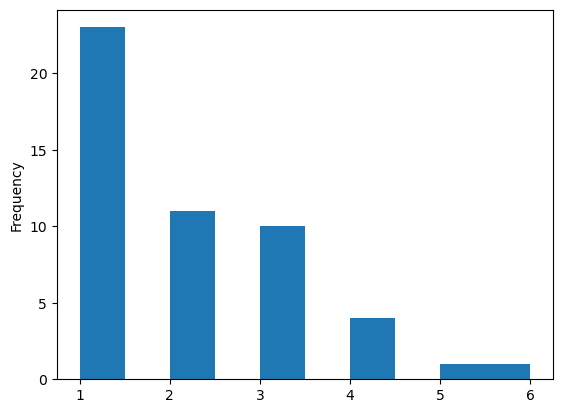

In [69]:
challenges_columns = [col for col in df.columns if col.startswith('challenges_adoption')]
challenges_melted = merge_columns(df, challenges_columns)
challenges_melted.apply(lambda x: len(x) if isinstance(x, list) else 0).plot(kind='hist')

In [70]:
# Step 1: Convert lists to sorted tuples so they can be counted and used as indices
tuples_series = challenges_melted.apply(lambda x: tuple(sorted(x)) if isinstance(x, list) else ())

# Step 2: Count the occurrences of each unique tuple
unique_lists_counts = tuples_series.value_counts()

# Step 3: Optionally convert the tuples back to lists for display
unique_lists_counts.index = unique_lists_counts.index.map(list)

# Display the unique lists and their counts
print(unique_lists_counts)

[Lack of expertise to implement]                                                                                                                                                                  8
[Unclear benefits]                                                                                                                                                                                5
[Cost prohibitive]                                                                                                                                                                                3
[Lack of expertise to implement, No time to spend on ethical assurance]                                                                                                                           3
[No time to spend on ethical assurance]                                                                                                                                                           2
[Lack of expertise t

In [71]:
# Specific item to search for
item1 = 'Lack of expertise to implement'
item2 = 'Cost prohibitive'
item3 = 'No time to spend on ethical assurance'
#filtered_pairs = [(idx, val) for idx, val in unique_lists_counts.items() if item in idx]
filtered_pairs = [(idx, val) for idx, val in unique_lists_counts.items() if all(item in idx for item in [item1,item2])]
# Display the filtered (index, value) pairs
filtered_pairs

[(['Cost prohibitive', 'Lack of expertise to implement'], 1),
 (['Cost prohibitive',
   "Doesn't fit into our governance process",
   'Internal resistance',
   'Lack of expertise to implement',
   'No time to spend on ethical assurance'],
  1),
 (['Cost prohibitive',
   "Doesn't integrate into our tech stack",
   'Lack of expertise to implement'],
  1),
 (['Cost prohibitive',
   "Doesn't fit into our governance process",
   'Lack of expertise to implement',
   'Unclear benefits'],
  1),
 (['Cost prohibitive', 'Lack of expertise to implement', 'Unclear benefits'],
  1),
 (['Cost prohibitive',
   "Doesn't integrate into our tech stack",
   'Lack of expertise to implement',
   'Unclear benefits'],
  1)]